# 图像中[多条]线的描述性统计
在研究图像中多条线的强度时，可以在GPU上并行进行。本笔记本为说明目的仅演示了两条线。可以假设在GPU上并行读取数百或数千条线在性能方面是有意义的。

In [1]:
import pyclesperanto_prototype as cle
from skimage.data import cells3d
import numpy as np

为了演示潜在的用例，我们仔细观察一张表达膜标记物的细胞图像。

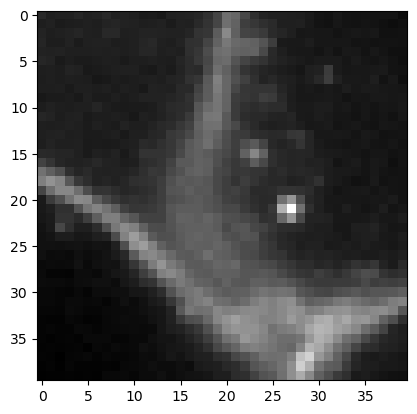

In [2]:
membranes = cells3d()[30, 0, 110:150, 110:150]
cle.imshow(membranes)

我们定义四个点的坐标，这些点将连接成两条线。连接将使用一个_touch_矩阵完成，该矩阵允许将n个点与n个点连接。

In [3]:
coords = np.asarray([
    [0, 17],  # line 1 start (x, y)
    [10, 24], # line 1 end
    [20, 21], # line 2
    [35, 21]
]).T

In [4]:
connection_matrix = cle.symmetric_maximum_matrix(np.asarray([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0], # this connects the two points of line 1
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1], # this connects the two points of line 2
    [0, 0, 0, 0, 0]
]))
connection_matrix

cl.OCLArray([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

首先，我们在膜图像上可视化这些线。

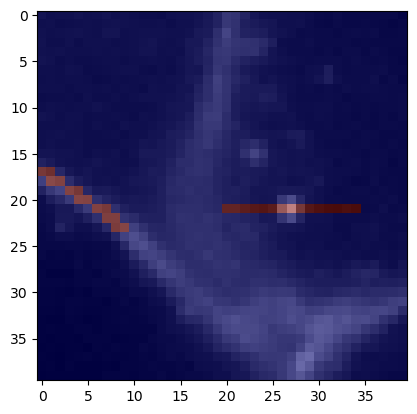

In [5]:
mesh = cle.create_like(membranes)
mesh = cle.touch_matrix_to_mesh(coords, connection_matrix, mesh)

cle.imshow(membranes, continue_drawing=True)
cle.imshow(mesh, alpha=0.5, colormap='jet')

## 测量线上的平均强度
接下来，我们使用上面配置的矩阵来测量线上的平均强度。我们还需要指定在线上将采样多少个点。

In [6]:
num_samples = 10

mean_intensity_matrix = cle.generate_mean_intensity_between_points_matrix(
                                membranes, coords, connection_matrix, num_samples=num_samples)
mean_intensity_matrix

cl.OCLArray([[   0. ,    0. ,    0. ,    0. ,    0. ],
       [   0. ,    0. , 7317.8,    0. ,    0. ],
       [   0. , 7317.8,    0. ,    0. ,    0. ],
       [   0. ,    0. ,    0. ,    0. , 4482.6],
       [   0. ,    0. ,    0. , 4482.6,    0. ]], dtype=float32)

我们也可以将这些测量结果再次可视化为线。由于我们以矩阵形式传递点和点之间的连接，从技术上讲这是一个网格。

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
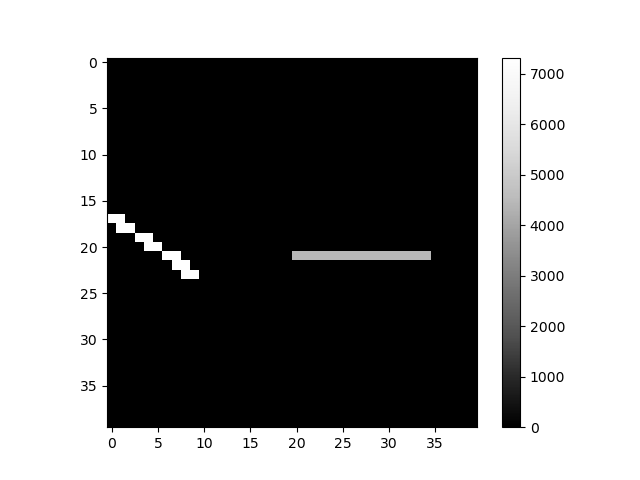
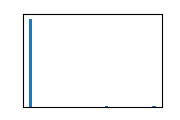

In [7]:
mean_intensity_mesh = cle.create_like(membranes)
mean_intensity_mesh = cle.touch_matrix_to_mesh(coords, mean_intensity_matrix, mean_intensity_mesh)
mean_intensity_mesh

我们还可以在原始膜图像上可视化这个定量网格。

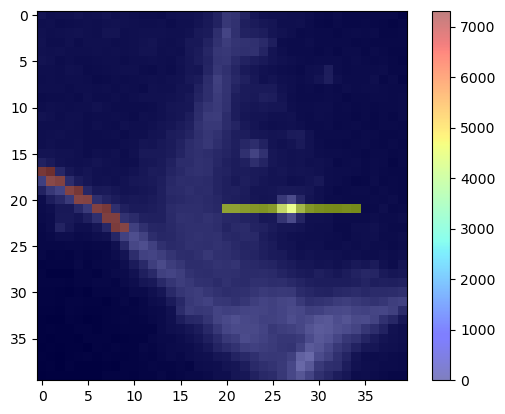

In [8]:
cle.imshow(membranes, continue_drawing=True)
cle.imshow(mean_intensity_mesh, alpha=0.5, colormap='jet', colorbar=True)

## 测量线上的强度标准差
同样的程序也适用于测量线上的标准差。

In [9]:
stddev_intensity_matrix = cle.generate_standard_deviation_intensity_between_points_matrix(
                                membranes, coords, connection_matrix)
stddev_intensity_matrix

cl.OCLArray([[   0.     ,    0.     ,    0.     ,    0.     ,    0.     ],
       [   0.     ,    0.     ,  572.79144,    0.     ,    0.     ],
       [   0.     ,  572.79144,    0.     ,    0.     ,    0.     ],
       [   0.     ,    0.     ,    0.     ,    0.     , 3758.1768 ],
       [   0.     ,    0.     ,    0.     , 3758.1772 ,    0.     ]],
      dtype=float32)

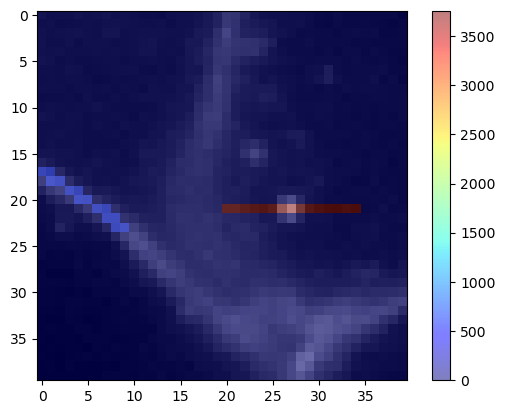

In [10]:
stddev_intensity_mesh = cle.create_like(membranes)
stddev_intensity_mesh = cle.touch_matrix_to_mesh(coords, stddev_intensity_matrix, stddev_intensity_mesh)

cle.imshow(membranes, continue_drawing=True)
cle.imshow(stddev_intensity_mesh, alpha=0.5, colormap='jet', colorbar=True)